# RPGRIP1 and Associated Syndrome


Variants in [RPGRIP1](https://omim.org/entry/605446) are associated with [cone-rod dystrophy-13 (CORD13)] and
[Leber congenital amaurosis 6](https://omim.org/entry/613826). Both conditions follow an autosomal recessive
mode of inheritance.

Data in this cohort are dervied from [Beryozkin A, et al. (2021) Retinal Degeneration Associated With RPGRIP1: A Review of Natural History, Mutation Spectrum, and Genotype-Phenotype Correlation in 228 Patients. Front Cell Dev Biol](https://pubmed.ncbi.nlm.nih.gov/34722527/)




In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}.')
print(f"Using gpsea version {gpsea.__version__}.")

Loaded HPO v2024-08-13.
Using gpsea version 0.7.1.


## RPGRIP1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for RPGRIP1.

In [3]:
gene_symbol = 'RPGRIP1'
mane_tx_id = 'NM_020366.4'
mane_protein_id = 'NP_065099.3' # X-linked retinitis pigmentosa GTPase regulator-interacting protein 1 isoform 1

In [5]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets


phenopacket_registry = configure_phenopacket_registry()
cohort_name = "RPGRIP1"
with phenopacket_registry.open_phenopacket_store('0.1.21') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))
print(f"Imported {len(phenopackets)} phenopackets from cohort {cohort_name}")

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Imported 100 phenopackets from cohort RPGRIP1
Individuals Processed: 100%|██████████| 100/100 [00:02<00:00, 35.33individuals/s]
Loaded 100 individuals
Validated under permissive policy
No errors or warnings were found


In [6]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Nystagmus,HP:0000639,75
Abnormal electroretinogram,HP:0000512,49
Reduced visual acuity,HP:0007663,43
Hypermetropia,HP:0000540,40
Very low visual acuity,HP:0032122,39
Eye poking,HP:0001483,35
Retinal pigment epithelial mottling,HP:0007814,33
Attenuation of retinal blood vessels,HP:0007843,30
Retinal degeneration,HP:0000546,19
Photophobia,HP:0000613,17


In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_54275/1613228306.py:4: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


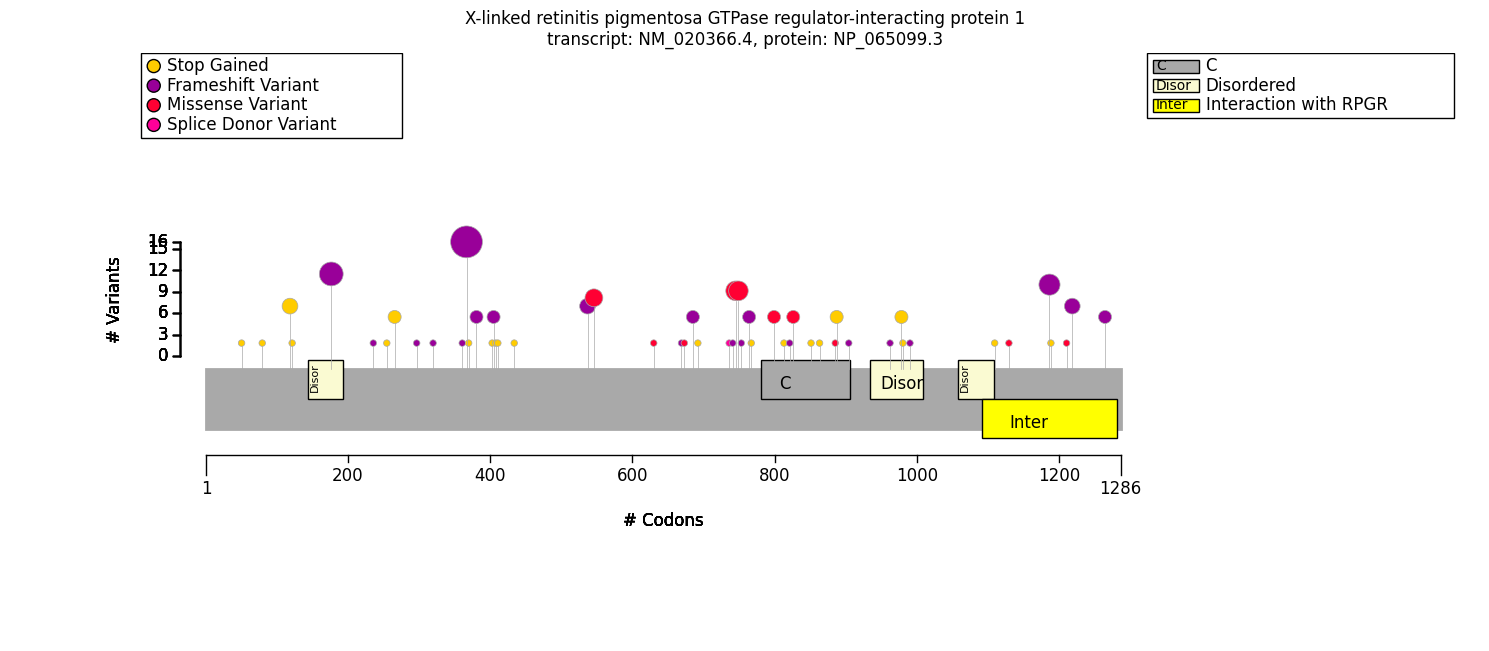

In [7]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
rpgrip1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
rpgrip1_fig.tight_layout()

In [8]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Name,Type,Coordinates,Count,Variants
Disordered,COILED_COIL,144 - 193,8,p.Glu179SerfsTer11
C2,DOMAIN,781 - 906,12,p.Arg814Ter; p.Glu800Lys; p.Leu886Phe; p.Arg827Leu; p.Arg888Ter; p.Tyr864Ter; p.Arg852Ter; p.Asn907Ter; p.Ala824IlefsTer11
Disordered,COILED_COIL,934 - 1008,5,p.Arg981Ter; p.Gln979Ter; p.Arg992GlufsTer9; p.Ser964ProfsTer37
Disordered,COILED_COIL,1058 - 1108,0,
Interaction with RPGR,COILED_COIL,1091 - 1281,15,p.Tyr1110Ter; p.Glu1130Gln; p.Lys1221AsnfsTer23; p.Arg1189Ter; p.Val1211Glu; p.Val1265GlyfsTer19; p.Arg1189GlyfsTer7


In [9]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
14_21312457_21312458_GA_G,c.1107del,p.Glu370AsnfsTer5,10,frameshift,16
14_21302530_21302531_AG_A,c.535del,p.Glu179SerfsTer11,5,frameshift,8
14_21345139_21345146_CAAGGCCG_C,c.3565_3571del,p.Arg1189GlyfsTer7,23,frameshift,6
14_21325252_21325252_G_A,c.2236G>A,p.Gly746Arg,16,missense,5
14_21325265_21325265_A_G,c.2249A>G,p.Tyr750Cys,16,missense,5
14_21321881_21321881_G_T,c.1639G>T,p.Ala547Ser,14,missense,4
14_21348210_21348214_AAAAG_A,c.3663_3666del,p.Lys1221AsnfsTer23,24,frameshift,3
14_21326544_21327883_--1340bp--_A,c.2710+374_2895+78del,None,18,"splice acceptor, splice donor, splice donor 5th base, coding sequence, intronic",3
14_21321855_21321865_AGGAACTGGAG_A,c.1615_1624del,p.Glu539GlnfsTer2,14,"frameshift, splice region",3
14_21301105_21301105_C_T,c.358C>T,p.Gln120Ter,4,stop gained,3


# Genotype Phenotype Correlation (GPC) Analysis
Consider: A homozygous structural variant of RPGRIP1 is
frequently associated with achromatopsia in Japanese
patients with IRD


16	14_21312457_21312458_GA_G	c.1107del	p.Glu370AsnfsTer5

In [10]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [13]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates,VariantPredicate

vp = VariantPredicates.variant_key("14_21312457_21312458_GA_G")  #	c.1107del	p.Glu370AsnfsTer5	

from gpsea.analysis.predicate.genotype import biallelic_predicate
gt_predicate = biallelic_predicate(
    a_predicate=vp,
    b_predicate=~vp,
    a_label="1107del",
    b_label="other",
    partitions = ({0,1}, {2,})
)
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,13
HMF08,Skipping general term,24
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,60


In [14]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                      1107del/1107del OR 1107del/other  \
                                                                             Count   
Eye poking [HP:0001483]                                                      16/16   
Very low visual acuity [HP:0032122]                                          11/11   
Photophobia [HP:0000613]                                                       0/5   
Hypermetropia [HP:0000540]                                                   16/16   
Retinal pigment epithelial mottling [HP:0007814]                             11/13   
Attenuation of retinal blood vessels [HP:0007843]                              5/5   
Nystagmus [HP:0000639]                                                       11/11   
Abnormal involuntary eye movements [HP:0012547]                              11/11   
Sensory behavioral abnormality [HP:5200046]                                  16/16   
Atypical behavior [HP:0000708]                                               16/16   
Abnormality of retinal pigmentation [HP:0007703]                             13/13   
Abnormal retinal morphology [HP:0000479]                                     14/14   
Abnormal fundus morphology [HP:0001098]                                      14/14   
Reduced visual acuity [HP:0007663]                                           16/16   
Visual impairment [HP:0000505]                                               16/16   
Abnormal electroretinogram [HP:0000512]                                        5/5   

Allele group                                              other/other          \
                                                  Percent       Count Percent   
Eye poking [HP:0001483]                              100%       19/41     46%   
Very low visual acuity [HP:0032122]                  100%       28/44     64%   
Photophobia [HP:0000613]                               0%       17/37     46%   
Hypermetropia [HP:0000540]                           100%       24/27     89%   
Retinal pigment epithelial mottling [HP:0007814]      85%       22/33     67%   
Attenuation of retinal blood vessels [HP:0007843]    100%       25/37     68%   
Nystagmus [HP:0000639]                               100%       64/71     90%   
Abnormal involuntary eye movements [HP:0012547]      100%       64/64    100%   
Sensory behavioral abnormality [HP:5200046]          100%       35/35    100%   
Atypical behavior [HP:0000708]                       100%       35/35    100%   
Abnormality of retinal pigmentation [HP:0007703]     100%       30/30    100%   
Abnormal retinal morphology [HP:0000479]             100%       66/66    100%   
Abnormal fundus morphology [HP:0001098]              100%       67/67    100%   
Reduced visual acuity [HP:0007663]                   100%       82/82    100%   
Visual impairment [HP:0000505]                       100%       82/82    100%   
Abnormal electroretinogram [HP:0000512]              100%       44/44    100%   

Allele group                                                                    
                                                  Corrected p values  p values  
Eye poking [HP:0001483]                                     0.002076  0.000130  
Very low visual acuity [HP:0032122]                         0.183424  0.022928  
Photophobia [HP:0000613]                                    0.371899  0.069731  
Hypermetropia [HP:0000540]                                  0.795761  0.282392  
Retinal pigment epithelial mottling [HP:0007814]            0.795761  0.293313  
Attenuation of retinal blood vessels [HP:0007843]           0.795761  0.298410  
Nystagmus [HP:0000639]                                      1.000000  0.585610  
Abnormal involuntary eye movements [HP:0012547]             1.000000  1.000000  
Sensory behavioral abnormality [HP:5200046]                 1.000000  1.000000  
Atypical behavior [HP:0000708]                              1.000000  1.000000  
Abnormality of retin

In [15]:
is_frameshift = VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)

gt_predicate = biallelic_predicate(
    a_predicate=is_frameshift,
    b_predicate=~is_frameshift,
    a_label="frameshift",
    b_label="other",
    partitions = ({0,1}, {2,})
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)


summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                      frameshift/frameshift OR frameshift/other  \
                                                                                      Count   
Eye poking [HP:0001483]                                                               28/38   
Photophobia [HP:0000613]                                                               6/20   
Retinal pigment epithelial mottling [HP:0007814]                                      21/32   
Attenuation of retinal blood vessels [HP:0007843]                                     16/21   
Very low visual acuity [HP:0032122]                                                   24/33   
Nystagmus [HP:0000639]                                                                42/46   
Abnormal involuntary eye movements [HP:0012547]                                       42/42   
Sensory behavioral abnormality [HP:5200046]                                           34/34   
Atypical behavior [HP:0000708]                                                        34/34   
Abnormality of retinal pigmentation [HP:0007703]                                      28/28   
Abnormal retinal morphology [HP:0000479]                                              45/45   
Abnormal fundus morphology [HP:0001098]                                               46/46   
Reduced visual acuity [HP:0007663]                                                    55/55   
Visual impairment [HP:0000505]                                                        55/55   
Abnormal electroretinogram [HP:0000512]                                               24/24   
Hypermetropia [HP:0000540]                                                            29/31   

Allele group                                              other/other          \
                                                  Percent       Count Percent   
Eye poking [HP:0001483]                               74%        7/19     37%   
Photophobia [HP:0000613]                              30%       11/22     50%   
Retinal pigment epithelial mottling [HP:0007814]      66%       12/14     86%   
Attenuation of retinal blood vessels [HP:0007843]     76%       14/21     67%   
Very low visual acuity [HP:0032122]                   73%       15/22     68%   
Nystagmus [HP:0000639]                                91%       33/36     92%   
Abnormal involuntary eye movements [HP:0012547]      100%       33/33    100%   
Sensory behavioral abnormality [HP:5200046]          100%       17/17    100%   
Atypical behavior [HP:0000708]                       100%       17/17    100%   
Abnormality of retinal pigmentation [HP:0007703]     100%       15/15    100%   
Abnormal retinal morphology [HP:0000479]             100%       35/35    100%   
Abnormal fundus morphology [HP:0001098]              100%       35/35    100%   
Reduced visual acuity [HP:0007663]                   100%       43/43    100%   
Visual impairment [HP:0000505]                       100%       43/43    100%   
Abnormal electroretinogram [HP:0000512]              100%       25/25    100%   
Hypermetropia [HP:0000540]                            94%       11/12     92%   

Allele group                                                                    
                                                  Corrected p values  p values  
Eye poking [HP:0001483]                                     0.161287  0.010080  
Photophobia [HP:0000613]                                    1.000000  0.222477  
Retinal pigment epithelial mottling [HP:0007814]            1.000000  0.286434  
Attenuation of retinal blood vessels [HP:0007843]           1.000000  0.733718  
Very low visual acuity [HP:0032122]                         1.000000  0.767851  
Nystagmus [HP:0000639]                                      1.000000  1.000000  
Abnormal involuntary eye movements [HP:0012547]             1.000000  1.000000  
Sensory behavioral abnormality [HP:5200046]                 1.000000  1.000000  
Atypical behavior [H

In [16]:
is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

gt_predicate = biallelic_predicate(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="missense",
    b_label="other",
    partitions = ({0,}, {1, 2})
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                      missense/missense          \
                                                              Count Percent   
Nystagmus [HP:0000639]                                         9/12     75%   
Macular atrophy [HP:0007401]                                    3/5     60%   
Photophobia [HP:0000613]                                       8/14     57%   
Retinal pigment epithelial mottling [HP:0007814]                5/5    100%   
Eye poking [HP:0001483]                                         3/7     43%   
Very low visual acuity [HP:0032122]                             5/9     56%   
Abnormal involuntary eye movements [HP:0012547]                 9/9    100%   
Sensory behavioral abnormality [HP:5200046]                   11/11    100%   
Atypical behavior [HP:0000708]                                11/11    100%   
Abnormality of retinal pigmentation [HP:0007703]                8/8    100%   
Abnormal retinal morphology [HP:0000479]                      17/17    100%   
Abnormal fundus morphology [HP:0001098]                       17/17    100%   
Reduced visual acuity [HP:0007663]                            18/18    100%   
Visual impairment [HP:0000505]                                18/18    100%   
Abnormal electroretinogram [HP:0000512]                       10/10    100%   
Hypermetropia [HP:0000540]                                      6/6    100%   
Attenuation of retinal blood vessels [HP:0007843]              7/10     70%   

Allele group                                      missense/other OR other/other  \
                                                                          Count   
Nystagmus [HP:0000639]                                                    66/70   
Macular atrophy [HP:0007401]                                               9/35   
Photophobia [HP:0000613]                                                   9/28   
Retinal pigment epithelial mottling [HP:0007814]                          28/41   
Eye poking [HP:0001483]                                                   32/50   
Very low visual acuity [HP:0032122]                                       34/46   
Abnormal involuntary eye movements [HP:0012547]                           66/66   
Sensory behavioral abnormality [HP:5200046]                               40/40   
Atypical behavior [HP:0000708]                                            40/40   
Abnormality of retinal pigmentation [HP:0007703]                          35/35   
Abnormal retinal morphology [HP:0000479]                                  63/63   
Abnormal fundus morphology [HP:0001098]                                   64/64   
Reduced visual acuity [HP:0007663]                                        80/80   
Visual impairment [HP:0000505]                                            80/80   
Abnormal electroretinogram [HP:0000512]                                   39/39   
Hypermetropia [HP:0000540]                                                34/37   
Attenuation of retinal blood vessels [HP:0007843]                         23/32   

Allele group                                                                  \
                                                  Percent Corrected p values   
Nystagmus [HP:0000639]                                94%                1.0   
Macular atrophy [HP:0007401]                          26%                1.0   
Photophobia [HP:0000613]                              32%                1.0   
Retinal pigment epithelial mottling [HP:0007814]      68%                1.0   
Eye poking [HP:0001483]                               64%                1.0   
Very low visual acuity [HP:0032122]                   74%                1.0   
Abnormal involuntary eye movements [HP:0012547]      100%                1.0   
Sensory behavioral abnormality [HP:5200046]          100%                1.0   
Atypical behavior [HP:0000708]                       100%                1.0   
Abnormality of retinal pigmentation [HP:

In [17]:
from gpsea.analysis.predicate.genotype import sex_predicate
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, result)

Sex                                               FEMALE           MALE  \
                                                   Count Percent  Count   
Attenuation of retinal blood vessels [HP:0007843]  14/17     82%  15/24   
Very low visual acuity [HP:0032122]                20/25     80%  19/29   
Nystagmus [HP:0000639]                             36/38     95%  36/41   
Hypermetropia [HP:0000540]                         23/25     92%  17/17   
Retinal pigment epithelial mottling [HP:0007814]   20/27     74%  12/18   
Eye poking [HP:0001483]                            20/31     65%  15/25   
Abnormal involuntary eye movements [HP:0012547]    36/36    100%  36/36   
Sensory behavioral abnormality [HP:5200046]        25/25    100%  22/22   
Atypical behavior [HP:0000708]                     25/25    100%  22/22   
Abnormality of retinal pigmentation [HP:0007703]   24/24    100%  18/18   
Abnormal retinal morphology [HP:0000479]           37/37    100%  38/38   
Abnormal fundus morphology [HP:0001098]            37/37    100%  39/39   
Reduced visual acuity [HP:0007663]                 44/44    100%  49/49   
Visual impairment [HP:0000505]                     44/44    100%  49/49   
Abnormal electroretinogram [HP:0000512]            21/21    100%  22/22   

Sex                                                                           \
                                                  Percent Corrected p values   
Attenuation of retinal blood vessels [HP:0007843]     62%                1.0   
Very low visual acuity [HP:0032122]                   66%                1.0   
Nystagmus [HP:0000639]                                88%                1.0   
Hypermetropia [HP:0000540]                           100%                1.0   
Retinal pigment epithelial mottling [HP:0007814]      67%                1.0   
Eye poking [HP:0001483]                               60%                1.0   
Abnormal involuntary eye movements [HP:0012547]      100%                1.0   
Sensory behavioral abnormality [HP:5200046]          100%                1.0   
Atypical behavior [HP:0000708]                       100%                1.0   
Abnormality of retinal pigmentation [HP:0007703]     100%                1.0   
Abnormal retinal morphology [HP:0000479]             100%                1.0   
Abnormal fundus morphology [HP:0001098]              100%                1.0   
Reduced visual acuity [HP:0007663]                   100%                1.0   
Visual impairment [HP:0000505]                       100%                1.0   
Abnormal electroretinogram [HP:0000512]              100%                1.0   

Sex                                                          
                                                   p values  
Attenuation of retinal blood vessels [HP:0007843]  0.296352  
Very low visual acuity [HP:0032122]                0.361592  
Nystagmus [HP:0000639]                             0.433832  
Hypermetropia [HP:0000540]                         0.506388  
Retinal pigment epithelial mottling [HP:0007814]   0.739452  
Eye poking [HP:0001483]                            0.785927  
Abnormal involuntary eye movements [HP:0012547]    1.000000  
Sensory behavioral abnormality [HP:5200046]        1.000000  
Atypical behavior [HP:0000708]                     1.000000  
Abnormality of retinal pigmentation [HP:0007703]   1.000000  
Abnormal retinal morphology [HP:0000479]           1.000000  
Abnormal fundus morphology [HP:0001098]            1.000000  
Reduced visual acuity [HP:0007663]                 1.000000  
Visual impairment [HP:0000505]                     1.000000  
Abnormal electroretinogram [HP:0000512]            1.000000

# LCA6 and CRD13

Both Leber congenital amaurosis 6 (OMIM:613826) and Cone-rod dystrophy 13 (OMIM:608194	) are caused by pathogenic variation in RPGRIP1. The following code searches for phenotypic features that are significantly different between both diseases. We find that Very low visual acuity and Nystagmus are significantly more common in LCA6.

In [18]:
from gpsea.analysis.predicate.genotype import diagnosis_predicate

dx_predicate = diagnosis_predicate(
    diagnoses=('OMIM:613826', 'OMIM:608194'),
    labels=('LCA6', 'CRD13'),
)

dx_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=dx_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, dx_result)



Diagnosis                                         OMIM:613826          \
                                                        Count Percent   
Very low visual acuity [HP:0032122]                     35/39     90%   
Nystagmus [HP:0000639]                                  64/66     97%   
Macular atrophy [HP:0007401]                             6/29     21%   
Attenuation of retinal blood vessels [HP:0007843]       23/28     82%   
Photophobia [HP:0000613]                                 8/23     35%   
Abnormal involuntary eye movements [HP:0012547]         64/64    100%   
Sensory behavioral abnormality [HP:5200046]             42/42    100%   
Atypical behavior [HP:0000708]                          42/42    100%   
Abnormality of retinal pigmentation [HP:0007703]        36/36    100%   
Abnormal retinal morphology [HP:0000479]                66/66    100%   
Abnormal fundus morphology [HP:0001098]                 67/67    100%   
Reduced visual acuity [HP:0007663]                      77/77    100%   
Visual impairment [HP:0000505]                          77/77    100%   
Abnormal electroretinogram [HP:0000512]                 34/34    100%   
Hypermetropia [HP:0000540]                              36/39     92%   

Diagnosis                                         OMIM:608194          \
                                                        Count Percent   
Very low visual acuity [HP:0032122]                      4/16     25%   
Nystagmus [HP:0000639]                                  11/16     69%   
Macular atrophy [HP:0007401]                             6/11     55%   
Attenuation of retinal blood vessels [HP:0007843]        7/14     50%   
Photophobia [HP:0000613]                                 9/19     47%   
Abnormal involuntary eye movements [HP:0012547]         11/11    100%   
Sensory behavioral abnormality [HP:5200046]               9/9    100%   
Atypical behavior [HP:0000708]                            9/9    100%   
Abnormality of retinal pigmentation [HP:0007703]          7/7    100%   
Abnormal retinal morphology [HP:0000479]                14/14    100%   
Abnormal fundus morphology [HP:0001098]                 14/14    100%   
Reduced visual acuity [HP:0007663]                      21/21    100%   
Visual impairment [HP:0000505]                          21/21    100%   
Abnormal electroretinogram [HP:0000512]                 15/15    100%   
Hypermetropia [HP:0000540]                                4/4    100%   

Diagnosis                                                                       
                                                  Corrected p values  p values  
Very low visual acuity [HP:0032122]                         0.000078  0.000005  
Nystagmus [HP:0000639]                                      0.019549  0.002607  
Macular atrophy [HP:0007401]                                0.249859  0.056323  
Attenuation of retinal blood vessels [HP:0007843]           0.249859  0.066629  
Photophobia [HP:0000613]                                    1.000000  0.531096  
Abnormal involuntary eye movements [HP:0012547]             1.000000  1.000000  
Sensory behavioral abnormality [HP:5200046]                 1.000000  1.000000  
Atypical behavior [HP:0000708]                              1.000000  1.000000  
Abnormality of retinal pigmentation [HP:0007703]            1.000000  1.000000  
Abnormal retinal morphology [HP:0000479]                    1.000000  1.000000  
Abnormal fundus morphology [HP:0001098]                     1.000000  1.000000  
Reduced visual acuity [HP:0007663]                          1.000000  1.000000  
Visual impairment [HP:0000505]                              1.000000  1.000000  
Abnormal electroretinogram [HP:0000512]                     1.000000  1.000000  
Hypermetropia [HP:0000540]                                  1.000000  1.000000